# Project Introduction

The first project of the Data Scientist Nanodegree program is to pick a dataset, explore it, analyse it and present the analysis in a blog post.


For this project I picked the Stackoverflow Developer Survey Data for 2020 to answer the following questions:

1) Average salary of genders between UK and Greece

2) Job satisfaction of genders between UK and Greece

3) Education level of genders between UK and Greece

4) Current popular languages between UK and greece

5) Desirable languages between UK and Greece



*It should be noted that for this analysis the Google Colab notebook was used.  Colab allows anybody to write and execute arbitrary python code through the browser, and is especially well suited to machine learning, data analysis and education.*

*It has some differences in importing the data from a local machine. Apart from that the same libraries are used with the jupyter notebook. *

# Import files for the analysis

In [1]:
import pandas as pd
from google.colab import files
import io
from IPython.display import display
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns; sns.set_theme(); sns.set(rc={'figure.figsize':(12,8)})
%matplotlib inline


# below command is used in Colab to open a window and choose the file to read. 
# it creates a dictionary - uploaded - with a key,value pair for each chosen file for upload
uploaded = files.upload()

Saving survey_results_public.csv to survey_results_public.csv


In [3]:
# 2020 data
#results_shema = pd.read_csv(io.BytesIO(uploaded['survey_results_schema.csv']))
survey = pd.read_csv(io.BytesIO(uploaded['survey_results_public.csv']))
# results_shema['year'] = 2020

# Functions built for the analysis

In [52]:
def clean_gender(rawGender):
    """
    function to clean the Gender column to have only one entry per Respondent
    """
    g_list = str(rawGender).split(';')
    if len(g_list) == 0 or 'nan' in g_list:
      gender = "Not Provided"
    elif len(g_list) == 1 and 'Non-binary, genderqueer, or gender non-conforming' not in g_list:
      gender = g_list[0]
    elif 'Non-binary, genderqueer, or gender non-conforming' in g_list or ('Woman' in g_list and 'Man' in g_list):
      gender = 'Non-binary,genderqueer,\n or gender non-conforming'
    elif 'Non-binary, genderqueer, or gender non-conforming' in g_list:
      gender = 'Non-binary,genderqueer,\n or gender non-conforming'
    else:
      gender = rawGender
    return gender



def heatmaps_comparison(data,countries, comparison_columns,title_names, count_column = 'Respondent',default_group_column = 'Country'):
  """
  The function gets the dataset, the countries and columns to filter it accordingly.
  then produces 2 heatmaps (one for each country) on the columns that are compared 
  """
  #chosen columns
  chosen_cols = [default_group_column,count_column] + comparison_columns
  gr_uk_jobsat = data[chosen_cols].loc[data[default_group_column].isin(countries)]
  
  chosen_cols.remove(count_column)
  gruk_js_sum = gr_uk_jobsat.groupby(chosen_cols)[count_column].count().reset_index()

  gruk_js_pvt = pd.pivot_table(gruk_js_sum, values=count_column, index=comparison_columns,columns=[default_group_column]).reset_index()

  dict_df = {}

  f, axes = plt.subplots(1, 2,sharey = True)
  sns.set(rc={'figure.figsize':(12,8)})
  i = 0
  for country in countries:
    dict_df['{}_df'.format(country)] = pd.pivot_table(gruk_js_pvt, values=country, index=comparison_columns[1],columns=[comparison_columns[0]]).reset_index(comparison_columns[1]).fillna(0).rename_axis(None, axis=1)
    dict_df['{}_df'.format(country)].set_index(comparison_columns[1], inplace=True)
    dict_df['{}_ax'.format(country)] = sns.heatmap(dict_df['{}_df'.format(country)], annot=True, ax=axes[i], fmt='g')
    dict_df['{}_ax'.format(country)].set_title("{level1} per {level0} for {country}".format(level1 = title_names[1],level0 = title_names[0],country=country))
    i += 1


def compare_languages_with_graph(column_for_comp,countries,title,default_group_column = 'Country'):
  """
  this function is built to compare the choises of the respondent for i.e. most desired languages
  between the choosen countries.
  """

  chosen_cols = [default_group_column,column_for_comp]
  countries_data = data[chosen_cols].loc[data[default_group_column].isin(countries)]
  study = countries_data[chosen_cols].value_counts().reset_index()

  study['break_into_list'] = study[column_for_comp].apply(lambda x: x.split(';'))

  df_country = dict()
  for country in countries:
    final_list = []
    
    # for each row in the break_into list column, append in a list to flatten it
    for row in study['break_into_list'].loc[data[default_group_column] == country]:
      for item in row:
        final_list.append(item)

    # save counter in a dictionary for easy access
    cnt_dct = dict(Counter(final_list))
    df_country[country] = pd.DataFrame.from_dict(cnt_dct, orient='index',columns=['cnt'])

  # build a dataframe with % of values per country to be used in the graph
  for i in range(len(countries)):
    if i==0:
      common_df = df_country[countries[i]].merge(df_country[countries[i+1]], how='outer', right_index=True, left_index=True, suffixes=(': {}'.format(countries[i]), ': {}'.format(countries[i+1])))
    else:
      common_df = df_country[countries[i]].merge(common_df, how='outer', right_index=True, left_index=True, suffixes=(': {}'.format(countries[i]), ''))

    common_df[countries[i]] = round(100*common_df['cnt: {}'.format(countries[i])]/common_df['cnt: {}'.format(countries[i])].sum(),2)
    del common_df['cnt: {}'.format(countries[i])]

  del common_df['cnt']
  common_df.fillna(0,inplace=True)
  common_df.sort_values(countries[0],inplace=True)

  common_df.plot(kind='barh')
  plt.xlabel('Percentage to total per {}'.format(default_group_column))
  plt.title("{} in {} for 2020".format(title,str(countries)[1:-1]))

# Dataset checks

In [4]:
print("survey dataset info")
display(survey.info())

# print("\nsurvey dataset missing values check")
# display(survey.isna().sum())

print("\nsurvey dataset view")
display(survey.head(2))

# print("\nresults_shema dataset view")
# display(results_shema.head())

survey dataset info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64461 entries, 0 to 64460
Data columns (total 61 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Respondent                    64461 non-null  int64  
 1   MainBranch                    64162 non-null  object 
 2   Hobbyist                      64416 non-null  object 
 3   Age                           45446 non-null  float64
 4   Age1stCode                    57900 non-null  object 
 5   CompFreq                      40069 non-null  object 
 6   CompTotal                     34826 non-null  float64
 7   ConvertedComp                 34756 non-null  float64
 8   Country                       64072 non-null  object 
 9   CurrencyDesc                  45472 non-null  object 
 10  CurrencySymbol                45472 non-null  object 
 11  DatabaseDesireNextYear        44070 non-null  object 
 12  DatabaseWorkedWith            49537 non-

None


survey dataset view


,Respondent,MainBranch,Hobbyist,Age,Age1stCode,CompFreq,CompTotal,ConvertedComp,Country,CurrencyDesc,CurrencySymbol,DatabaseDesireNextYear,DatabaseWorkedWith,DevType,EdLevel,Employment,Ethnicity,Gender,JobFactors,JobSat,JobSeek,LanguageDesireNextYear,LanguageWorkedWith,MiscTechDesireNextYear,MiscTechWorkedWith,NEWCollabToolsDesireNextYear,NEWCollabToolsWorkedWith,NEWDevOps,NEWDevOpsImpt,NEWEdImpt,NEWJobHunt,NEWJobHuntResearch,NEWLearn,NEWOffTopic,NEWOnboardGood,NEWOtherComms,NEWOvertime,NEWPurchaseResearch,NEWPurpleLink,NEWSOSites,NEWStuck,OpSys,OrgSize,PlatformDesireNextYear,PlatformWorkedWith,PurchaseWhat,Sexuality,SOAccount,SOComm,SOPartFreq,SOVisitFreq,SurveyEase,SurveyLength,Trans,UndergradMajor,WebframeDesireNextYear,WebframeWorkedWith,WelcomeChange,WorkWeekHrs,YearsCode,YearsCodePro
0,1,I am a developer by profession,Yes,NaN,13,Monthly,NaN,NaN,Germany,European Euro,EUR,Microsoft SQL Server,Elasticsearch;Microsoft SQL Server;Oracle,"Developer, desktop or enterprise applications;...","Master’s degree (M.A., M.S., M.Eng., MBA, etc.)","Independent contractor, freelancer, or self-em...",White or of European descent,Man,"Languages, frameworks, and other technologies ...",Slightly satisfied,I am not interested in new job opportunities,C#;HTML/CSS;JavaScript,C#;HTML/CSS;JavaScript,.NET Core;Xamarin,.NET;.NET Core,Microsoft Teams;Microsoft Azure;Trello,Confluence;Jira;Slack;Microsoft Azure;Trello,No,Somewhat important,Fairly important,NaN,NaN,Once a year,Not sure,NaN,No,Often: 1-2 days per week or more,Start a free trial;Ask developers I know/work ...,Amused,Stack Overflow (public Q&A for anyone who codes),Visit Stack Overflow;Go for a walk or other ph...,Windows,2 to 9 employees,Android;iOS;Kubernetes;Microsoft Azure;Windows,Windows,NaN,Straight / Heterosexual,No,"No, not at all",NaN,Multiple times per day,Neither easy nor difficult,Appropriate in length,No,"Computer science, computer engineering, or sof...",ASP.NET Core,ASP.NET;ASP.NET Core,Just as welcome now as I felt last year,50.0,36,27
1,2,I am a developer by profession,No,NaN,19,NaN,NaN,NaN,United Kingdom,Pound sterling,GBP,NaN,NaN,"Developer, full-stack;Developer, mobile","Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Employed full-time,NaN,NaN,NaN,Very dissatisfied,I am not interested in new job opportunities,Python;Swift,JavaScript;Swift,React Native;TensorFlow;Unity 3D,React Native,Github;Slack,Confluence;Jira;Github;Gitlab;Slack,NaN,NaN,Fairly important,NaN,NaN,Once a year,Not sure,NaN,No,NaN,NaN,Amused,Stack Overflow (public Q&A for anyone who code...,Visit Stack Overflow;Go for a walk or other ph...,MacOS,"1,000 to 4,999 employees",iOS;Kubernetes;Linux;MacOS,iOS,I have little or no influence,NaN,Yes,"Yes, definitely",Less than once per month or monthly,Multiple times per day,NaN,NaN,NaN,"Computer science, computer engineering, or sof...",NaN,NaN,Somewhat more welcome now than last year,NaN,7,4


# Take subset of survey for analysis and explore it

In [5]:
data = survey[['Respondent','Gender','Hobbyist','Country','Employment','YearsCode','UndergradMajor','EdLevel','DevType',
'MainBranch','JobSat','ConvertedComp','CompFreq','CompTotal','CurrencySymbol', 'LanguageDesireNextYear', 'LanguageWorkedWith']]

print("missing values %")
round((data.isna().sum()/len(data))*100,2).sort_values()

missing values %


Respondent                 0.00
Hobbyist                   0.07
MainBranch                 0.46
Country                    0.60
Employment                 0.94
YearsCode                 10.51
EdLevel                   10.91
LanguageWorkedWith        10.99
LanguageDesireNextYear    16.05
UndergradMajor            20.89
Gender                    21.57
DevType                   23.41
CurrencySymbol            29.46
JobSat                    29.89
CompFreq                  37.84
CompTotal                 45.97
ConvertedComp             46.08
dtype: float64

In [6]:
print("\nexplore Country of respondents")
print((data.Country.value_counts()/len(data))*100)
print("\nexplore Job Satisfaction of respondents")
print(data.JobSat.value_counts())
print("\nexplore Education Level of respondents")
print(data.EdLevel.value_counts())
print("\nexplore Gender of respondents")
print(data.Gender.value_counts())


explore Country of respondents
United States     19.343479
India             13.035789
United Kingdom     6.043965
Germany            6.034657
Canada             3.398954
                    ...    
Liechtenstein      0.001551
Saint Lucia        0.001551
Lesotho            0.001551
Nauru              0.001551
Mali               0.001551
Name: Country, Length: 183, dtype: float64

explore Job Satisfaction of respondents
Very satisfied                        14611
Slightly satisfied                    13930
Slightly dissatisfied                  7124
Neither satisfied nor dissatisfied     5783
Very dissatisfied                      3746
Name: JobSat, dtype: int64

explore Education Level of respondents
Bachelor’s degree (B.A., B.S., B.Eng., etc.)                                          26542
Master’s degree (M.A., M.S., M.Eng., MBA, etc.)                                       13112
Some college/university study without earning a degree                                 7239
Secondary sch

# 1) avg salary of genders between UK and Greece

,Respondent,ConvertedComp
Country,,
Greece,390,43611.731343
United Kingdom,3896,140849.074189


/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


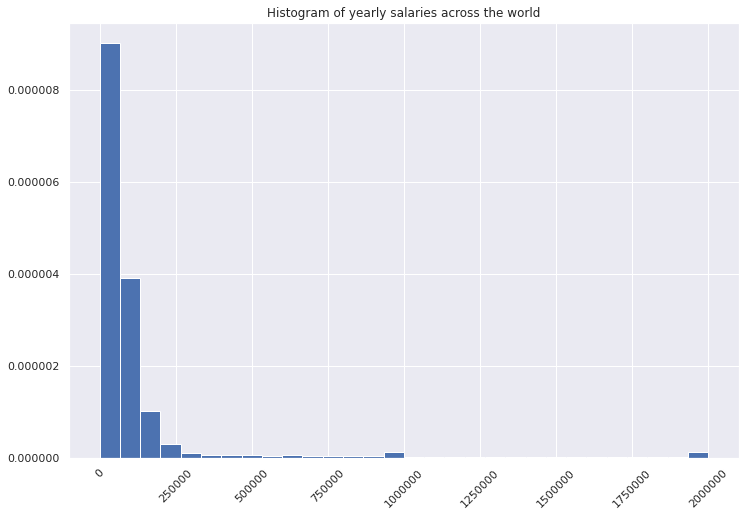

In [40]:
#get participants and their average salary from UK and Greece
gr_uk = data[['Country','Respondent', 'ConvertedComp']].loc[data['Country'].isin(['United Kingdom','Greece'])]
display(gr_uk.groupby('Country').agg({'Respondent':'count', 'ConvertedComp':'mean'}))

# get a global view distribution of yearly salaries
plt.hist(data['ConvertedComp'], density=True, bins=30);
plt.title("Histogram of yearly salaries across the world")
plt.ticklabel_format(style='plain')
plt.xticks(rotation=45)
plt.show()


explore cleanGender of respondents


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,cleanGender
Man,46013
Not Provided,13904
Woman,3844
"Non-binary,genderqueer,\n or gender non-conforming",700


,ConvertedComp
cleanGender,
Woman,98300.480651
Man,103615.911778
"Non-binary,genderqueer,\n or gender non-conforming",107977.579327
Not Provided,109376.081400


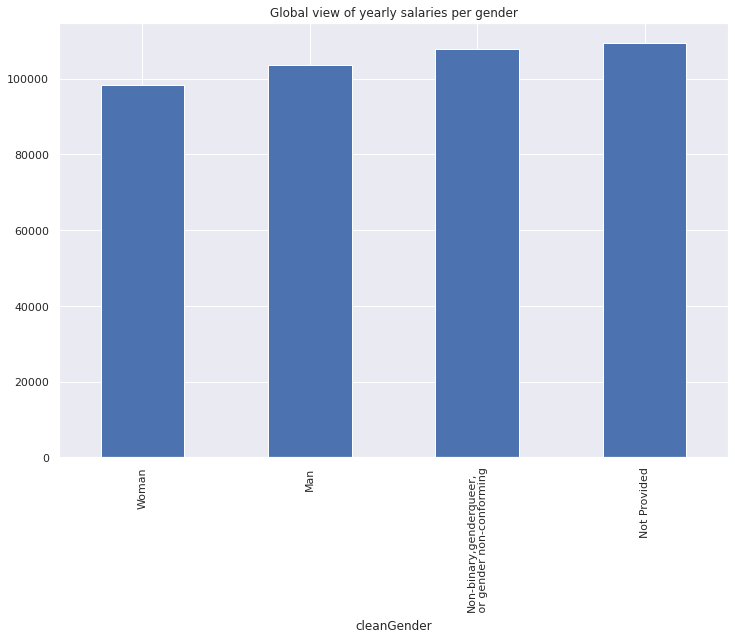

In [44]:
# create cleaned Gedner column
data['cleanGender'] =  data['Gender'].apply(lambda x: clean_gender(x) )
print("\nexplore cleanGender of respondents")
display(pd.DataFrame(data.cleanGender.value_counts()))

# display average yearly salary per Gender
salary_per_gender = data.groupby('cleanGender')['ConvertedComp'].mean().sort_values()
display(pd.DataFrame(salary_per_gender.head()))
salary_per_gender.plot.bar()
plt.title("Global view of yearly salaries per gender")
plt.show()

Country,Greece,United Kingdom
cleanGender,,
Man,88.059701,83.616692
"Non-binary,genderqueer,\n or gender non-conforming",0.497512,1.159196
Not Provided,6.467662,6.761978
Woman,4.975124,8.462133


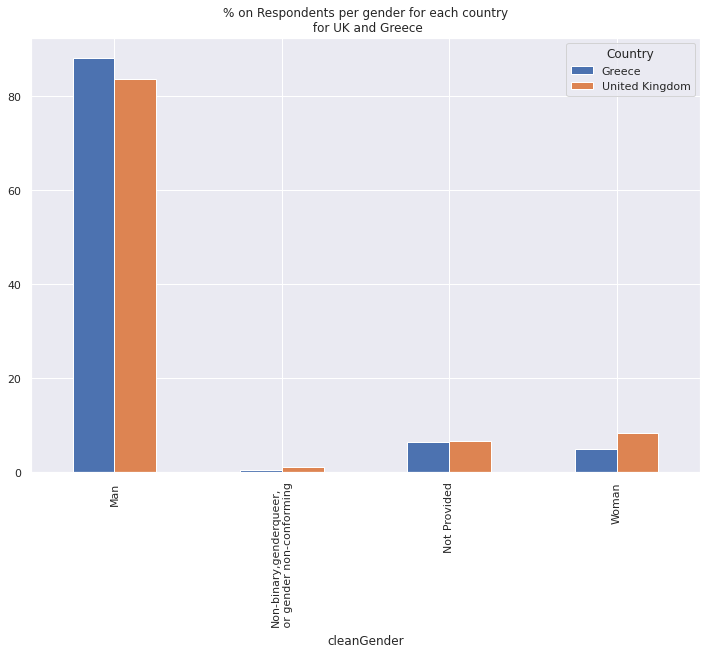

In [45]:
# get salary and gender for the chosen countries
# on the selected data drop missing values. This basically afects only the salary column.
# as it is the column we are comparing between genders and countries it makes sense to drop missing data
gr_uk = data[['Country','Respondent', 'ConvertedComp','cleanGender']].loc[data['Country'].isin(['United Kingdom','Greece'])]
gr_uk_nonan = gr_uk.dropna()

# get the count and average salary per gender and country
gruk_vols = gr_uk_nonan.groupby(['cleanGender','Country']).agg({'Respondent':'count', 'ConvertedComp':'mean'})

# pivot the table to make the country information for the count of respondents appear horizontically
gruk_resp = pd.pivot_table(gruk_vols, values='Respondent', index=['cleanGender'],columns=['Country'])

# get the % of respondents per gender to the total respondents from each country
gruk_resp['Greece'] = 100*gruk_resp['Greece']/sum(gruk_resp['Greece'])
gruk_resp['United Kingdom'] = 100*gruk_resp['United Kingdom']/sum(gruk_resp['United Kingdom'])

#plot the % of respondents per gender and country
display(gruk_resp)
gruk_resp.plot.bar()
plt.title("% on Respondents per gender for each country\n for UK and Greece")
plt.show()

Country,Greece,United Kingdom
cleanGender,,
Man,45675.435028,143659.468115
"Non-binary,genderqueer,\n or gender non-conforming",70264.000000,130810.633333
Not Provided,25758.538462,148117.937143
Woman,27628.100000,108645.465753


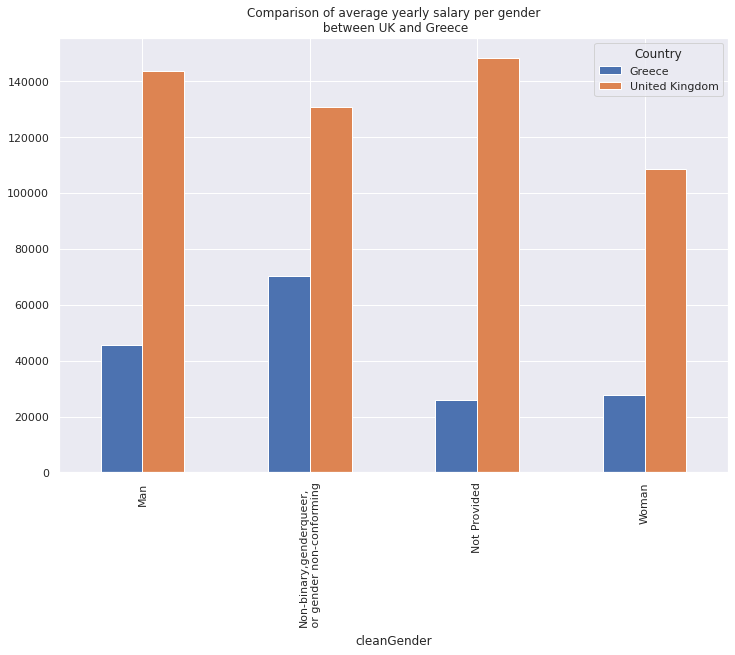

In [46]:
# pivot the table to make the country information for the average salary per gender appear horizontically
gruk_comp = pd.pivot_table(gruk_vols, values='ConvertedComp', index=['cleanGender'],columns=['Country'])
display(gruk_comp)

#plot the average yearly salary per gender and country
gruk_comp.plot.bar()
plt.title("Comparison of average yearly salary per gender\n between UK and Greece")
plt.show()

# 2) job satisfaction of genders between UK and Greece

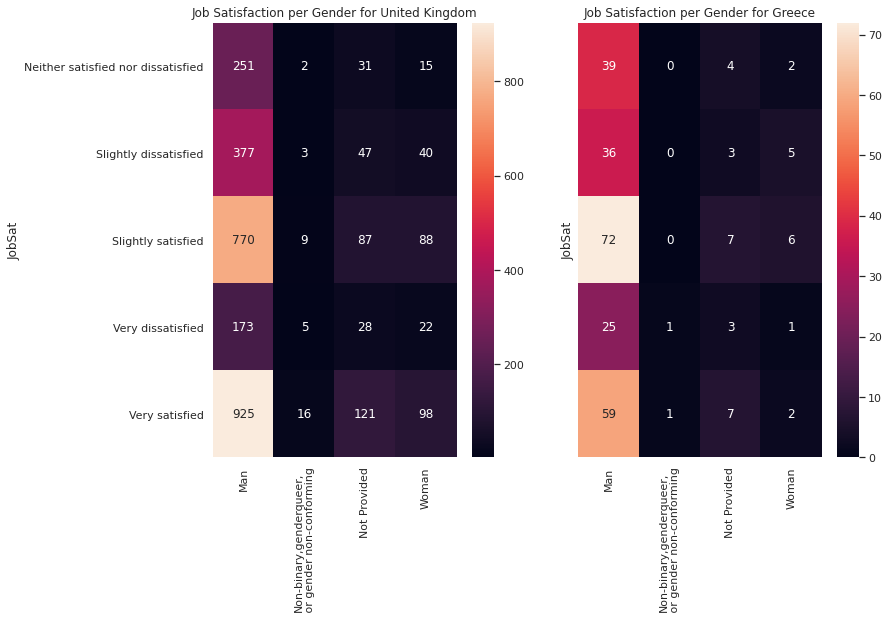

In [54]:
heatmaps_comparison(data,['United Kingdom','Greece'],['cleanGender','JobSat'],['Gender','Job Satisfaction'])

# 3) education level of genders between UK and Greece

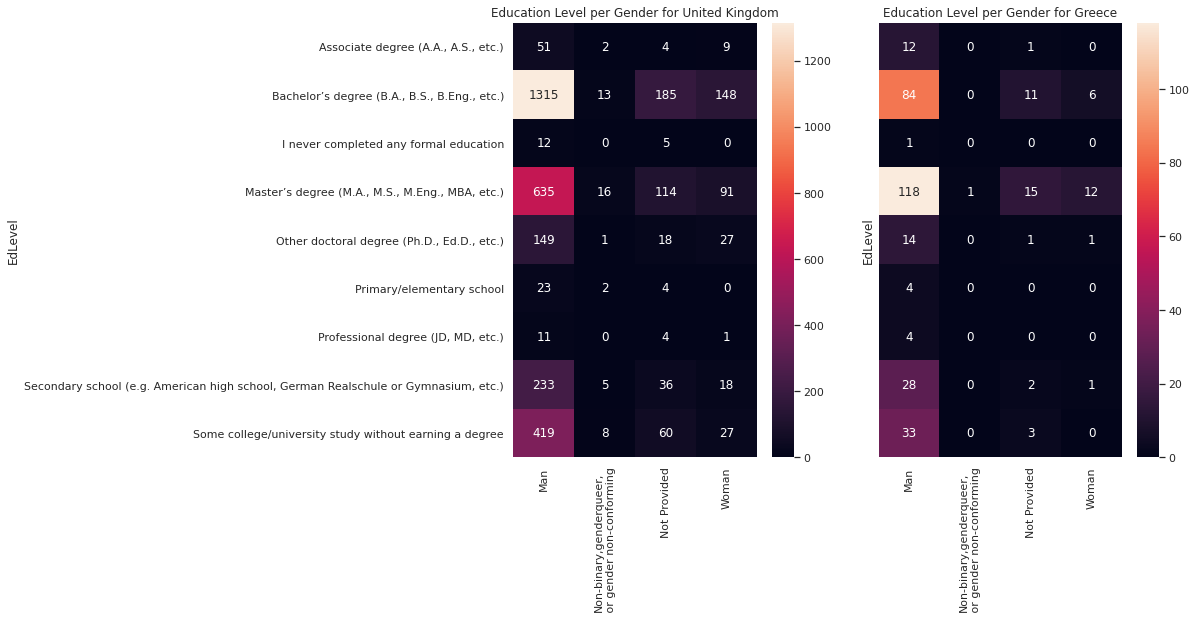

In [53]:
heatmaps_comparison(data,['United Kingdom','Greece'],['cleanGender','EdLevel'],['Gender','Education Level'])

# 4) current popular languages between UK and greece

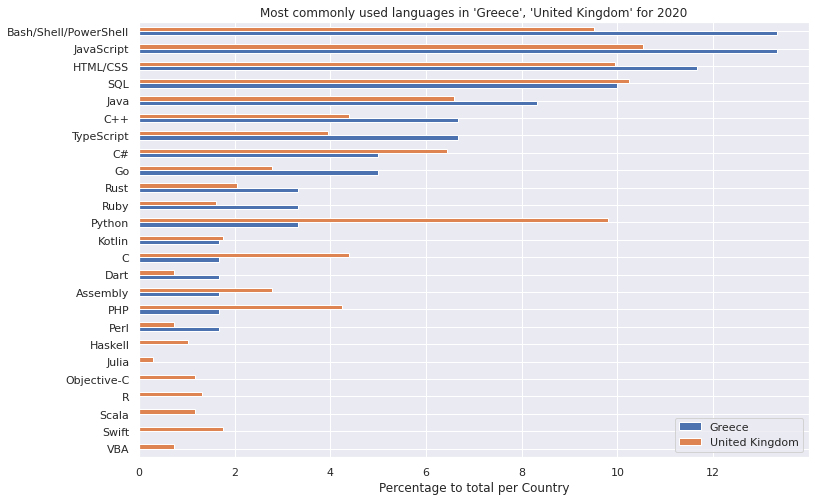

In [42]:
compare_languages_with_graph('LanguageWorkedWith',['Greece','United Kingdom'],"Most commonly used languages")


# 5)desirable languages between UK and Greece

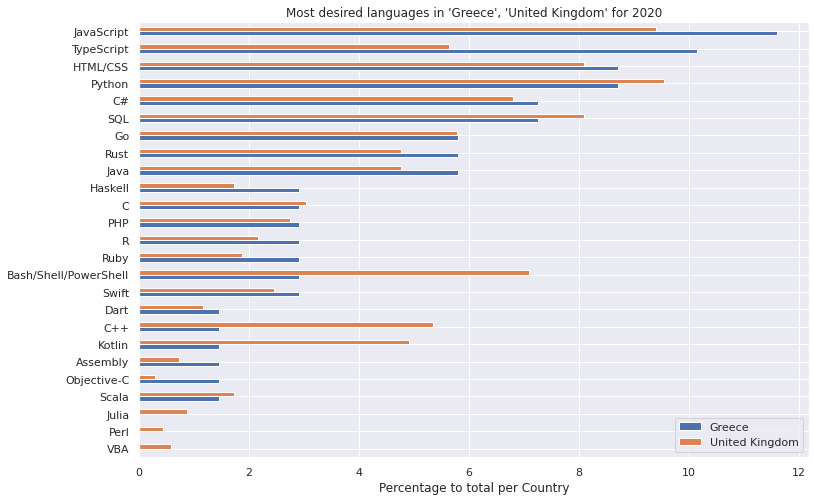

In [35]:
compare_languages_with_graph('LanguageDesireNextYear',['Greece','United Kingdom'],"Most desired languages")

# End of analysis